# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [111]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact


In [112]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY")

# Set the Mapbox API
px.set_mapbox_access_token(mapbox_token)

# Import Data

In [113]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [114]:
sfo_data.head()

,neighborhood,sale_price_sqr_foot,housing_units,gross_rent
year,,,,
2010,Alamo Square,291.182945,372560,1239
2010,Anza Vista,267.932583,372560,1239
2010,Bayview,170.098665,372560,1239
2010,Buena Vista Park,347.394919,372560,1239
2010,Central Richmond,319.027623,372560,1239


In [115]:
df_neighborhood_locations.head()

,Neighborhood,Lat,Lon
0,Alamo Square,37.791012,-122.402100
1,Anza Vista,37.779598,-122.443451
2,Bayview,37.734670,-122.401060
3,Bayview Heights,37.728740,-122.410980
4,Bernal Heights,37.728630,-122.443050


In [116]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    # Calculate the mean number of housing units per year
    grp_housing_units = sfo_data["housing_units"].groupby("year").mean()

    # create figure and assign to pane  
    housing_units_fig = plt.figure()
    housing_units_plot = grp_housing_units.plot.bar(x='year', ylim=[grp_housing_units.min()-4000, grp_housing_units.max()+2000], 
                                                    title="Housing Units in San Francisco from 2010 to 2016")
    plt.close(housing_units_fig)

    return pn.pane.Matplotlib(housing_units_fig)

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    # Calculate the average gross rent and average sale price per square foot
    sfo_avg = pd.DataFrame(
        {
            "sale_price_sqr_foot": sfo_data["sale_price_sqr_foot"].groupby([sfo_data.index]).mean(),
            "gross_rent": sfo_data["gross_rent"].groupby(sfo_data.index).mean()
        })
    
     # create figure and assign to pane  
    avg_gross_rent_fig = plt.figure()
    average_gross_rent = sfo_avg["gross_rent"].plot.line(title='Average Gross Rent in San Francisco')
    plt.close(avg_gross_rent_fig)
    
    return pn.pane.Matplotlib(avg_gross_rent_fig)

def average_sales_price():
    """Average Sales Price Per Year."""
    
        # Calculate the average gross rent and average sale price per square foot
    sfo_avg = pd.DataFrame(
    {
            "sale_price_sqr_foot": sfo_data["sale_price_sqr_foot"].groupby([sfo_data.index]).mean(),
            "gross_rent": sfo_data["gross_rent"].groupby(sfo_data.index).mean()
    })
    
     # create figure and assign to pane  
    avg_sales_fig = plt.figure()
    avg_sales_price = sfo_avg["sale_price_sqr_foot"].plot(title='Average Sales Price per Square Fooot in San Francisco')
    plt.close(avg_sales_fig)
    
    return pn.pane.Matplotlib(avg_sales_fig)


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""

    # Group by year and neighborhood and then create a new dataframe of the mean values
    sfo_avg_neighborhood = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
    sfo_sales = sfo_avg_neighborhood["sale_price_sqr_foot"]
    sfo_sales_df = pd.DataFrame(sfo_sales).reset_index()
    
    # Define function to choose a neighborhood
    def choose_neighborhood(neighborhood):
        return sfo_sales_df.loc[sfo_sales_df['neighborhood']==neighborhood,:].hvplot.line(
            x="year",
            y="sale_price_sqr_foot",
            colormap="plasma",
            title="San Fran Sale Sq/ft per Year",
        )

    # Declare one list of years to be used in a Panel select list
    list_of_neighborhoods = sfo_sales_df["neighborhood"].unique()
    # Execute interact function
    
    return interact(choose_neighborhood, neighborhood=list_of_neighborhoods)


def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    
    # Getting the data from the top 10 expensive neighborhoods
    ten_most_expensive = sfo_data.groupby("neighborhood").mean()
    ten_most_expensive = ten_most_expensive.nlargest(10,'sale_price_sqr_foot').reset_index()
    
    top_most_expensive_neighborhoods = ten_most_expensive.hvplot.bar(x="neighborhood", xlabel='Neighborhood', y="sale_price_sqr_foot", ylabel='Avg. Sale Price per Square Foot', rot=45, width=1000, height=400).opts(
    title="Top 10 Expensive Neighborhoods in SFO"
)

    return top_most_expensive_neighborhoods

def parallel_coordinates():
    """Parallel Coordinates Plot."""
    
    ten_most_expensive = sfo_data.groupby("neighborhood").mean()
    ten_most_expensive = ten_most_expensive.nlargest(10,'sale_price_sqr_foot').reset_index()
    
    parallel_coordinates = px.parallel_coordinates(ten_most_expensive , color='sale_price_sqr_foot')
    
    return parallel_coordinates

def parallel_categories():
    """Parallel Categories Plot."""
    ten_most_expensive = sfo_data.groupby("neighborhood").mean()
    ten_most_expensive = ten_most_expensive.nlargest(10,'sale_price_sqr_foot').reset_index()
    
    parallel_categories = px.parallel_categories(
    ten_most_expensive,
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={
        "neighborhood": "Neighborhood",
        "sale_price_sqr_foot": "Sale Price SQ/FT.",
        "housing_units": "Housing Units",
        "gross_rent": "Gross Rent"
        },
    )
    
    return parallel_categories

def neighborhood_map():
    """Neighborhood Map"""
    #calculate mean of SFO neighborhood data
    sfo_avg_neighborhood = sfo_data.groupby("neighborhood").mean().reset_index().copy()
    
    #join the data
    avg_value_location = pd.concat([sfo_avg_neighborhood, df_neighborhood_locations], axis="columns", join="inner")
    avg_value_location = avg_value_location.drop("Neighborhood", axis=1).copy()
    
    neighborhood_map = px.scatter_mapbox(
        avg_value_location,
        lat="Lat",
        lon="Lon",
        color="gross_rent",
        zoom=10,
        size='sale_price_sqr_foot',
        title='Average Sale Price Per Square Food and Gross Rent in San Francisco'
    )

    return neighborhood_map

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [117]:
# Create panels to structure the layout of the dashboard
title = '#Real Estate Analysis of San Francisco from 2010-2016'
welcome_tab = pn.Column(title, neighborhood_map())

market_analysis_row = pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())

neighborhood_analysis_tab = pn.Column(average_price_by_neighborhood(),top_most_expensive_neighborhoods())


parallel_plots_tab = pn.Column( 
    parallel_categories(),
    parallel_coordinates()
)


# Create tabs
panel = pn.Tabs(("Welcome", welcome_tab), 
("Annual Market Analysis", market_analysis_row),
("Neighborhood Analysis", neighborhood_analysis_tab), 
("Parallel Plots Analysis", parallel_plots_tab))

## Serve the Panel Dashboard

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
    [2] Column
        [0] Column
            [0] Column
                [0] Select(name='neighborhood', options=['Alamo Square', ...], value='Alamo Square')
            [1] Row
                [0] HoloViews(Curve, name='interactive03020')
        [1] HoloViews(Bars)
    [3] Column
        [0] Plotly(Figure)
        [1] Plotly(Figure)
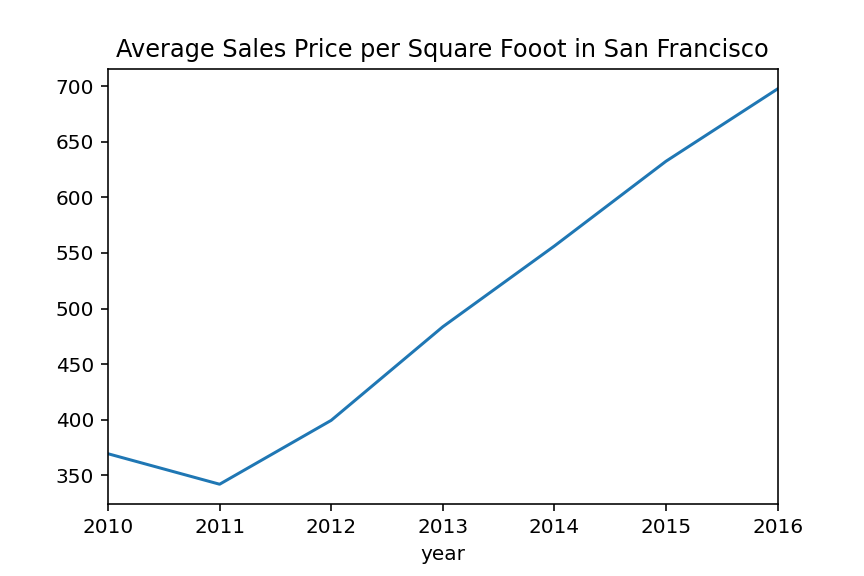
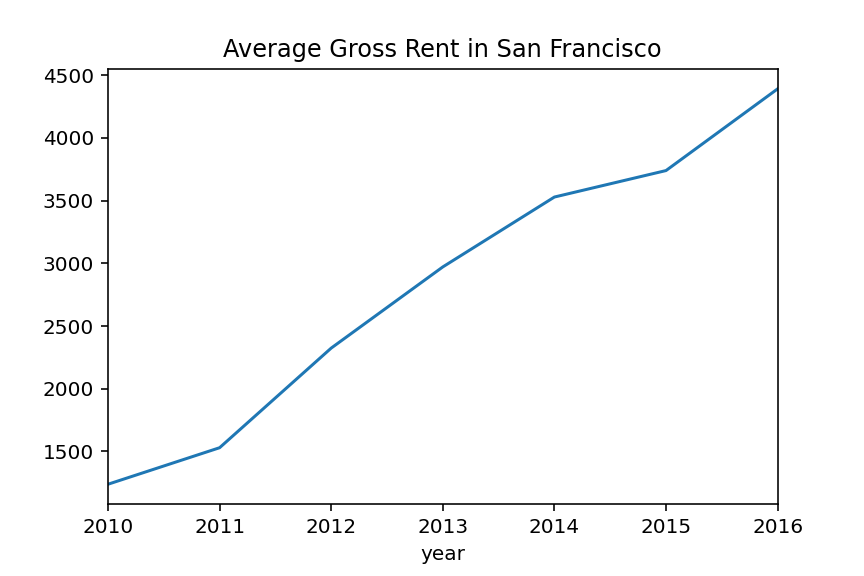
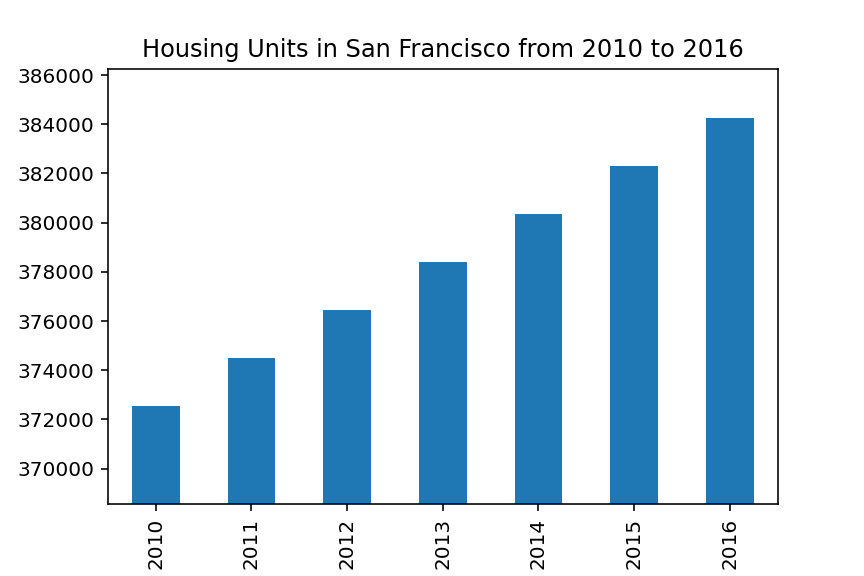

In [118]:
panel.servable()